# 载入套件

In [1]:
from typing import Dict
from tqdm.auto import tqdm

import numpy as np
import random
import pandas as pd
import ydata_profiling

import scienceplots
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

import torch
import os

%matplotlib inline

pd.plotting.register_matplotlib_converters()
sns.set_style("whitegrid")
sns.set_palette("RdBu")
sns.set(
    rc={'text.usetex': True},
    font="serif",
    font_scale=1.2
)

days = {i: pd.read_pickle(f'../Datasets/day{str(i).zfill(2)}.pkl')
        for i in range(1, 22)}

# 继承自2.2数据探索之类别变量
for i in range(1, 22):
    days[i]['app_type'] = days[i]['app_type'].replace(
        {'用户': 'usr', '预装': 'sys'})


# 单一变量

In [2]:
days[1].select_dtypes('number').describe()


,start_day,end_day,duration,up_flow,down_flow
count,5.335803e+06,5335803.0,5.335803e+06,5.335803e+06,5.335803e+06
mean,9.751070e-01,1.0,2.151605e+03,6.075722e+05,1.581638e+05
std,1.684390e+01,0.0,1.455335e+06,1.101550e+07,6.538530e+06
min,-1.652400e+04,1.0,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.0,3.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000e+00,1.0,1.000000e+01,0.000000e+00,0.000000e+00
75%,1.000000e+00,1.0,3.600000e+01,1.278000e+03,1.063000e+03
max,1.000000e+00,1.0,1.427770e+09,3.639474e+09,3.292713e+09


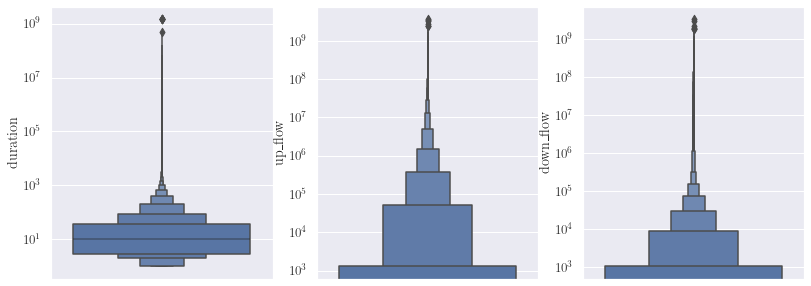

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(13.5, 5))

for i, x in enumerate(['duration', 'up_flow', 'down_flow']):
    g = sns.boxenplot(data=days[1], y=x, orient='v', ax=axes[i])
    g.set(
        yscale='log'
    )

plt.savefig("../Thesis/figures/boxenplot_duration_day01.pdf",
            dpi=400, bbox_inches='tight', pad_inches=0.005)


In [4]:
boss = 0
for i in range(1, 22):
    boss = max(boss, days[i]['duration'].quantile(0.9998))
boss


9158.023000001907

In [5]:
# days[1].query("uid == '64B3E40461C56847F35DB46D55707EA4'").sort_values(
#     by='end_time')


In [6]:
# days[1].query("uid == '1F1EF788E30A9EA8E8CB52059A4B02A0'").sort_values(
#     by='end_time')


In [7]:
days[19].query("app_class == 'a' & duration > 20000")


,uid,appid,app_type,app_class,start_day,start_time,end_day,end_time,duration,up_flow,down_flow
1673952,64B3E40461C56847F35DB46D55707EA4,4803,usr,a,19,00:52:46,19,07:47:59,24912,6572,9643


In [8]:
# 发现：有‘僵尸用户’（请求/活跃程度极低，监控记录中app_class均为NaN）
days[1][days[1]['uid'] == '3B0AAFBD3213D6DB0CCB17EDEAE80C38']


,uid,appid,app_type,app_class,start_day,start_time,end_day,end_time,duration,up_flow,down_flow
0,3B0AAFBD3213D6DB0CCB17EDEAE80C38,2859,sys,NaN,0,20:43:27,1,20:43:50,86423,0,0


In [9]:
# 数据清洗
for i in range(1, 22):
    days[i] = days[i].query('duration <= 9159')


In [10]:
days[1].select_dtypes('number').describe()


,start_day,end_day,duration,up_flow,down_flow
count,5.335042e+06,5335042.0,5.335042e+06,5.335042e+06,5.335042e+06
mean,9.993183e-01,1.0,6.039494e+01,5.912800e+05,1.511990e+05
std,2.610085e-02,0.0,2.196023e+02,1.001614e+07,6.069254e+06
min,0.000000e+00,1.0,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.0,3.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000e+00,1.0,1.000000e+01,0.000000e+00,0.000000e+00
75%,1.000000e+00,1.0,3.600000e+01,1.277000e+03,1.062000e+03
max,1.000000e+00,1.0,9.158000e+03,3.522792e+09,3.292713e+09


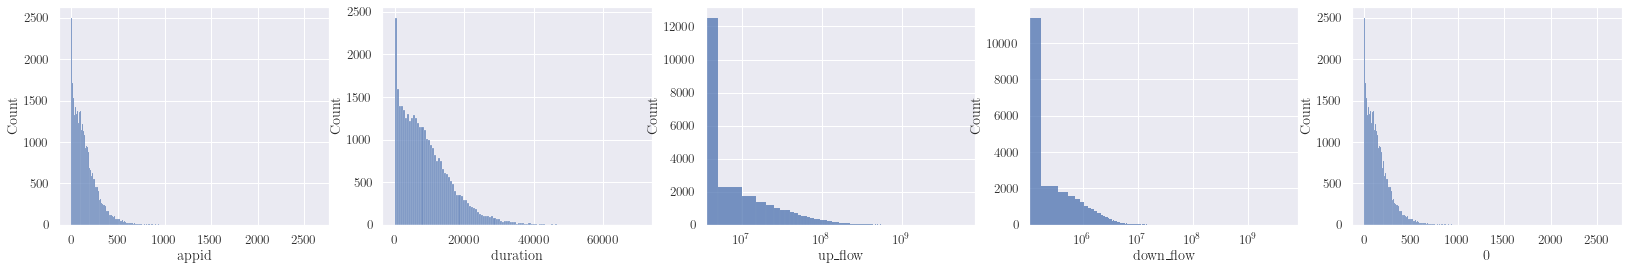

In [52]:
fig, axes = plt.subplots(1, 5, figsize=(28, 4))
ax = axes[0]
g = sns.histplot(
    data=days[1].pivot_table(
        index='uid',
        values='appid',
        aggfunc='count',
    ),
    ax=ax,
    x='appid'
)


ax = axes[1]
g = sns.histplot(
    data=days[1].pivot_table(
        index='uid',
        values='duration',
        aggfunc=np.sum
    ),
    ax=ax,
    x='duration'
)


ax = axes[2]
g = sns.histplot(
    data=days[1].pivot_table(
        index='uid',
        values='up_flow',
        aggfunc=np.sum
    ),
    ax=ax,
    x='up_flow',
)
g.set(
    xscale='log'
)

ax = axes[3]
g = sns.histplot(
    data=days[1].pivot_table(
        index='uid',
        values='down_flow',
        aggfunc=np.sum
    ),
    ax=ax,
    x='down_flow',
)
g.set(
    xscale='log'
)

ax = axes[4]
g = sns.histplot(
    data=pd.DataFrame(pd.DataFrame(
        days[1].groupby('uid').size()).to_records()),
    ax=ax,
    x='0',
)

plt.savefig("../Thesis/figures/histplots_appid_duration_upflow_downflow_lines.pdf",
            dpi=400, bbox_inches='tight', pad_inches=0.005)
